## Note: Please ensure you run this workbook from the same folder as where the underlying data files are stored in your computer.

# Preparing the Environment for Exploratory Data Analysis

In [2]:
# Imports of Models, Libraries & Date Parsing Functionality 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re
import math
import squarify
import plotly.express as px
import requests
import functools as ft

# Copy the YAML file and Twitter keys over to this Jupyter Notebook before you start to work.
import yaml
from yaml.loader import SafeLoader
from twitter import *
import tweepy

from pywaffle import Waffle
from datetime import datetime
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter

from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

# Setting up a date parser using a private funciton, lambda
# This will give us the dates in a format we require for aggregation & indexation
d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

# Exploring Twitter Data about Cycling

Is it at all worthwhile to look at cycling in London? Asides the traditional data that has bee supplied, the task here is to extract the most recent posts on Twitter about Cycling. From these, the objectives are:
- Discover locational information around where the topic generates the most social media content from 
- To see if any of the three cities being analysed are amongst these locations
- Get an overview of the sentiment expressed in such content on the topic
- Get an overview of the most common words used in such content to discover any underlying themes that can be explored further.

The output of this analysis using social data can be used as supplementary evidence to partially inform the hypothesis that Londoner's can be influenced to increase the uptake of cycling amongst them. 

In [3]:
# Copy the YAML file and Twitter keys over to this Jupyter Notebook before you start to work.
# Import the yaml file - remember to specify the whole path and use / between directories
twitter_creds = yaml.safe_load(open('twitter_tmp.yaml', 'r').read())

# To investigate the Tweets & Sentiment Analysis

nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\saura\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Pass Tweepy credentials
tweepy_api = Twitter(auth=OAuth(twitter_creds['access_token'],
                                 twitter_creds['access_token_secret'], 
                                 twitter_creds['api_key'],
                                 twitter_creds['api_secret_key'] ))

In [5]:
# Pass your Twitter credentials.
twitter_api = Twitter(auth=OAuth(twitter_creds['access_token'],
                                 twitter_creds['access_token_secret'], 
                                 twitter_creds['api_key'],
                                 twitter_creds['api_secret_key'] ))

In [6]:
# Check Tweepy connection
print(tweepy_api)

In [7]:
# Check Twitter connection
print(twitter_api)

## Building up the dataset

In [8]:
# Look for the term cycling on Twitter
# Ordered by recency
# Filtering for Tweets only in English
# Note that the free Twitter API being used here only allows access to the seven most recent days of tweets
# Looks for the most recent 4,000 tweets on cycling each time this is run

q = {'q':'cycling', 'lang':'en', 'count':100, 'result_type':'recent'}

# Results as an empty list.
results = []

while len(results) < 40:
    query = twitter_api.search.tweets(**q)
    q['max_id'] = query['search_metadata']['next_results'].split('&')[0].split('?max_id=')[1]
    results.append(query)
    
# Determine the number of results.
len(results)

# Repeat this process over several days to get a meaningfully large dataset
# continue this once a day for as long as possible

40

In [9]:
# Flatten the results in a DataFrame for NLP Analysis
df2 = pd.concat([pd.DataFrame(_['statuses']) for _ in results])

In [10]:
# Store the data as a backup
df2.to_csv('twitter_scrape_saurav_101022en.csv')

In [11]:
# Build up the data source from the daily extracts
df2 = pd.read_csv('twitter_scrape_saurav_071022en.csv')
df3 = pd.read_csv('twitter_scrape_saurav_081022en.csv')
df4 = pd.read_csv('twitter_scrape_saurav_091022en.csv')
df5 = pd.read_csv('twitter_scrape_saurav_101022en.csv')

# Means we are scraping c. 16,000 which have been extracted over the past 4 days
# Provides a much more meaningfully larger dataset compared to one day's worth of scraping

In [12]:
# Concatenate the datasets
# Creates a master dataset
Df = pd.concat([df2,df3,df4,df5])

In [13]:
# View output
Df.sample(5)

,Unnamed: 0,created_at,id,id_str,text,truncated,entities,extended_entities,metadata,source,...,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
1201,14,Sat Oct 08 23:07:31 +0000 2022,1578884827075743744,1578884827075743744,@moi_o_see @Boenau Is this the study that says...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",...,0,0,False,False,NaN,en,NaN,NaN,NaN,NaN
1357,85,Sun Oct 09 01:14:39 +0000 2022,1578916822338129922,1578916822338129922,I'm selling COURIER Bike Statement Cycling Cap...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://shopee.ph/mobile/"" rel=""nofoll...",...,0,0,False,False,False,en,NaN,NaN,NaN,NaN
1495,23,Sun Oct 09 00:36:56 +0000 2022,1578907329457979393,1578907329457979393,RT @NLinKosovo: Our Embassy brought @Cycling_E...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",...,5,0,False,False,NaN,en,{'created_at': 'Fri Oct 07 13:55:07 +0000 2022...,NaN,NaN,NaN
3381,9,Sat Oct 08 18:32:38 +0000 2022,1578815650692096001,1578815650692096001,RT @OperaChaser: Final destination on an after...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,1,0,False,False,NaN,en,{'created_at': 'Sat Oct 08 17:00:49 +0000 2022...,NaN,NaN,NaN
2260,88,Sat Oct 08 21:32:10 +0000 2022,1578860830115778560,1578860830115778560,RT @Biggreenbooks: Cycling fans! (or friends o...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",...,10,0,False,False,NaN,en,{'created_at': 'Sat Oct 08 20:49:53 +0000 2022...,NaN,NaN,NaN


In [14]:
# Check Metadata
Df.info()

# 15809 tweets so far

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15808 entries, 0 to 3861
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 15808 non-null  int64  
 1   created_at                 15808 non-null  object 
 2   id                         15808 non-null  int64  
 3   id_str                     15808 non-null  int64  
 4   text                       15808 non-null  object 
 5   truncated                  15808 non-null  bool   
 6   entities                   15808 non-null  object 
 7   extended_entities          1528 non-null   object 
 8   metadata                   15808 non-null  object 
 9   source                     15808 non-null  object 
 10  in_reply_to_status_id      4245 non-null   float64
 11  in_reply_to_status_id_str  4245 non-null   float64
 12  in_reply_to_user_id        4317 non-null   float64
 13  in_reply_to_user_id_str    4317 non-null   floa

In [15]:
# Parse the created_at column into pd datetime formate
Df['created_at'] = pd.to_datetime(Df.created_at)

In [16]:
# Search for duplicates & retain just the most recent tweet
# Look for duplicates and drop them based on created at and user

df = Df.drop_duplicates(subset = ['created_at', 'user', 'id'],
  keep = 'last').reset_index(drop = True)

# This avoids duplication of tweets created by the same user, at the same time & same id

In [17]:
# Check Metadata
df.info()

# Not much geo data captured. 
# User has geo data within it after keyword 'location' per Twitter API documentation
# 14,349 unique tweets extracted on cycling over 3 days so far.
# Need to keep running this process every day to build up a meaningfully large database

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14350 entries, 0 to 14349
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   Unnamed: 0                 14350 non-null  int64              
 1   created_at                 14350 non-null  datetime64[ns, UTC]
 2   id                         14350 non-null  int64              
 3   id_str                     14350 non-null  int64              
 4   text                       14350 non-null  object             
 5   truncated                  14350 non-null  bool               
 6   entities                   14350 non-null  object             
 7   extended_entities          1360 non-null   object             
 8   metadata                   14350 non-null  object             
 9   source                     14350 non-null  object             
 10  in_reply_to_status_id      3857 non-null   float64            
 11  in

In [18]:
# Extract user details into a seperate Df for later analysis
# Twitter Api docs indicate this field may contain location data
df1 = df['user'].values

In [19]:
# View one raw result
df1[2]
# Confirms user has many variables incl geo data

"{'id': 2222094857, 'id_str': '2222094857', 'name': 'Dan Coast (He/Him)', 'screen_name': 'coast_dan', 'location': 'Newport, Wales', 'description': 'Cyclist 🚴\\u200d♂️ and Star Wars fan #MTFBWY All views are my own. Dysgu Cymraeg 🏴\\U000e0067\\U000e0062\\U000e0077\\U000e006c\\U000e0073\\U000e007f', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 834, 'friends_count': 491, 'listed_count': 10, 'created_at': 'Thu Dec 12 20:05:17 +0000 2013', 'favourites_count': 8836, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 4457, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': 'http://pbs.

In [20]:
# Confirm how the data under user is presently stored
print(type(df1))

<class 'numpy.ndarray'>


In [21]:
# Check dimension of numpy array
np.shape(df1)
# No columns.

(14350,)

In [22]:
# Convert to pandas dataframe
user = pd.DataFrame(df1)

In [23]:
# Double check output
user.info()
# 1 Column with 14352 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14350 entries, 0 to 14349
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       14350 non-null  object
dtypes: object(1)
memory usage: 112.2+ KB


In [24]:
# Covert to Excel file & create columns there and reimport
user.to_csv('userA.csv')

# cleaned up shape somewhat in Excel to isolate some of the information 
# This is a task being done in Excel to keep the workbook here as compact as possible
# reload this cleaned up data later when doing analysis on location

In [25]:
# Determine the text of the actual tweet
df2 = df['text'].values

In [26]:
# View one raw result
# Confirms that the body of the post is stored here
df2[1]

'RT @SaveSoilSourav: @SadhguruJV @UNFCCC @cpsavesoil Grateful to all #SaveSoil heroes. Bow down to all of yours effort.\n\nCycling and Walking…'

## Prepare the data for NLP & Sentiment Analysis

In [27]:
# Introduce Stopwords
stop_words = set(stopwords.words('english'))

In [28]:
# Split up each tweet into individual words.
df2_token = [word_tokenize(_) for _ in df2]

# Not viewing all output to reduce size of workbook
# Just viewing one output instead
df2_token[5]

['🇨🇭Switzerland',
 'living',
 'up',
 'to',
 'it',
 "'s",
 'chocolate',
 'box',
 'reputation',
 'as',
 'Arlenis',
 'Sierra',
 '@',
 'Movistar_Team',
 'continues',
 'to',
 'build',
 'hers',
 ',',
 '…',
 'https',
 ':',
 '//t.co/tcsOYa0iJ9']

In [29]:
# Get a list of all English words so we can exclude anything that doesn't appear on the list.
all_english_words = set(words.words())

In [30]:
# Some pre-processing:
# Get every word.
# Convert it to lowercase.
# Only include if the word is alphanumeric and if it is in the list of English words.

df2_token_nostop =\
[[y.lower() for y in x if y.lower() not in stop_words and y.isalpha() and y.lower() in all_english_words]\
 for x in df2_token]

In [31]:
# View output
df2_token_nostop[5]

['living', 'chocolate', 'box', 'reputation', 'sierra', 'build']

In [32]:
# Create a variable to store the Sentiment Intensity Analyser
darth_vader = SentimentIntensityAnalyzer()

In [33]:
# Run through a dictionary comprehension to take every cleaned tweet. 
# Next run the polarity score function on the string.
# This will return four values in a dictionary.

df2_polarity =\
{" ".join(_) : darth_vader.polarity_scores(" ".join(_)) for _ in df2_token_nostop}

In [34]:
# Convert the list of dictionary results to a pandas dataframe. 
# The index is the cleaned tweet.

polarity_pd = pd.DataFrame(df2_polarity).T

# View the Dataframe
polarity_pd

# Compound score indicates actual sentiment

,neg,neu,pos,compound
ride cyclist,0.000,1.000,0.000,0.0000
grateful bow effort cycling,0.000,0.500,0.500,0.4588
need cycle infrastructure west going help vulnerable road enjoy,0.138,0.435,0.428,0.6124
doubt real,0.714,0.286,0.000,-0.3612
living chocolate box reputation sierra build,0.000,1.000,0.000,0.0000
...,...,...,...,...
medalist cycling men day,0.000,1.000,0.000,0.0000
behind tour follow great cycling team like never take tour,0.000,0.548,0.452,0.7650
weather weekend making last weekend cycling,0.000,1.000,0.000,0.0000
working apartment cycling broken us,0.437,0.563,0.000,-0.4767


### Visualising the data with Charts

Sentiment

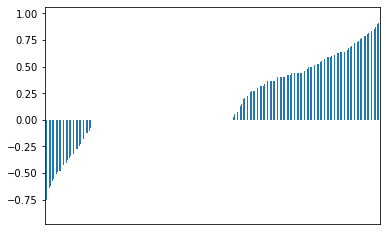

In [35]:
# Visualise the output in a distribution
%matplotlib inline
import matplotlib.pyplot as plt

_plot = polarity_pd.reset_index()['compound'].sort_values()
ax1 = plt.axes()
_plot.plot(kind='bar')

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

plt.show()
plt.close()

- Most values are 0 (neutral) - blank spaces
- More positive sentiment than negative sentiment amongst non-neutral values
- Some very strong positive sentiment > 0.75
- Some very strong negative sentiment also visible < -0.75

A histogram plot will visualise the distribution of sentiment better although the strictly neutral values should be removed which will help make the histogram clearer.

In [36]:
# Remove polarity values equal to zero 
# This will improve the scale of the histogram and remove all strictly neutral reviews from the analysis
# This will better highlight the distribution of polarity values = sentiment
# Define the source of the data to use for plotting histogram
data = polarity_pd['compound'][polarity_pd['compound'] != 0]

Text(0.5, 1.0, 'Non Neutral Sentiments from most recent Tweets on Cycling')

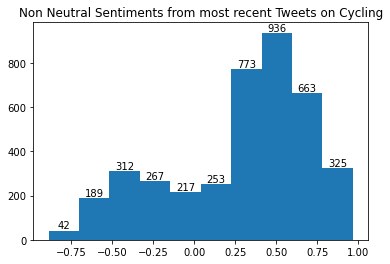

In [37]:
# Visualise the distribution of the sentiment analysis using histogram
count, edges, bars = plt.hist(data)
plt.bar_label(bars)
plt.title('Non Neutral Sentiments from most recent Tweets on Cycling')

# The exact numbers will change each time this notebook is rerun as the data will be changed
# Refresh the analytical content as this changes

# Many more strong positive sentiment (>0.75 polarity score) = 325 tweets
# Far fewer strongly negative sentiment (<-0.75 polarity score) = 42 tweets
# Indicates that on the whole from this small sample size, sentiment towards cycling is positive
# However, recall there are 14,349 unique tweets.
# Only c.28% of tweets display non 0 sentiment
# Means vast majority feel very neutral about cycling based on this data
# Indicates that there is room to improve sentiment towards cycling
# This can only come from increased cycling uptake.
# Worthwhile therefore to pursue increasing uptake of cycling
# Scope to increase cycling uptake established using sentiment analysis given
# Scope to increase non neutral sentiment on cycling
# General non neutral sentiment is positive so people should have no objection to at least trying out cycling

Top Words Visualised in a WordCloud

In [38]:
# Ensure all words are stored in a list which can then be used to create a WordClod
print(type(df2_token_nostop))

# Confirmed words are in a list

<class 'list'>


In [39]:
# View list
print(df2_token_nostop)

[['ride', 'cyclist'], ['grateful', 'bow', 'effort', 'cycling'], ['need', 'cycle', 'infrastructure', 'west', 'going', 'help', 'vulnerable', 'road', 'enjoy'], ['doubt', 'real'], ['grateful', 'bow', 'effort', 'cycling'], ['living', 'chocolate', 'box', 'reputation', 'sierra', 'build'], ['unit', 'found', 'evidence', 'support', 'viral'], ['four', 'people', 'different', 'history', 'walking', 'across'], ['driving', 'car', 'society', 'cycling', 'distance', 'society', 'source', 'city'], ['please', 'solve', 'math', 'get', 'password', 'lan', 'school', 'away', 'home'], ['still', 'improve', 'anything', 'cycling'], ['four', 'people', 'different', 'history', 'walking', 'across'], ['investigation', 'done', 'unit', 'found', 'evidence', 'cycling'], ['cycling', 'region', 'call', 'nationwide', 'uprising', 'military', 'dictatorship', 'people', 'continue'], ['cycling', 'across', 'best'], ['four', 'people', 'different', 'history', 'walking', 'across'], ['twitter', 'like', 'slows', 'rapid', 'cycling'], ['mind'

In [40]:
# Reformat list for use to generate wordcloud
s = ''.join(str(x) for x in df2_token_nostop)

In [41]:
# Check the most common items in the list 
# Will identify the obvious words which can be removed from the list before WordCloud is generated
# This will enhance the accuracy of the WordCloud
from collections import Counter
# split() returns list of all the words in the string
split_y = s.split()
  
# Pass the split_it list to instance of Counter class.
Counter = Counter(split_y)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(10)
  
print(most_occur)

# From these identify the most common words which fail to convey any meaning or sentiment

[("'cycling',", 5540), ("'transport',", 662), ("'like',", 608), ("'bike',", 595), ("'society',", 592), ("'new',", 554), ("'found',", 532), ("'support',", 520), ("'video',", 517), ("'people',", 495)]


In [42]:
# Remove cycling and other obv words from the list 
# Else they will skew the results
# Define these words as bespoke stopwords
stop_words = ['cycling', 'cycling ', 'distance', 'distance ', 'cyclingcycling', 'transport', 'found', 
              'evidence', 'transport ', 'bike ', 'helmet', 'cycle ', 'transport ', 
              'public', 'society', 'source', 'hour']

In [43]:
# Creating new list to avoid messing up orginal list
new_s = [word for word in s if word not in stop_words]

In [44]:
# Reformating into string again for wordcloud generation
st = ''.join(str(x) for x in new_s)

In [45]:
# Strip all punctuation
new_string = st.translate(str.maketrans('', '', string.punctuation))

In [46]:
# Generate Word Cloud using the most frequently used words when tweeting about cycling
wordcloud = (WordCloud(max_font_size=50, max_words=20, 
                       background_color="black").generate(new_string))

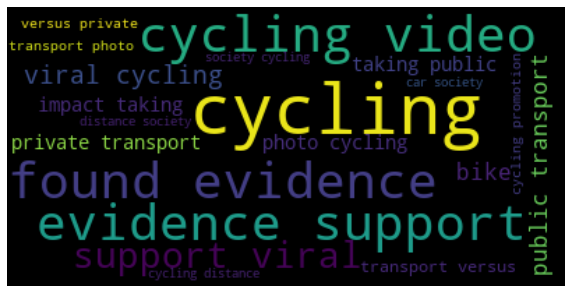

In [47]:
# Review: Display the WordCloud.
wordcloud.generate(new_string)
plt.figure(figsize=(10, 10))
plt.axis('off') 
plt.imshow(wordcloud, interpolation="bilinear")

# Displays the top 50 most commonly used words by Twitter users when they post about Cycling
# Relative Size displays frequency of the words
# There are words which suggest an ongoing debate about the potential merit of cycling
# Words such evidence, support, distance, public and private transport occur within the top 20 words
# These together suggest evidence of a public who are still debating the merits of cycling
# Reinforces the case for the trying to influence cycling uptake as any debate can within reason be influenced
# With mix of policy and strategic marketing

## Insights from Geo Data

Objective is to see the location of Twitter users posting about cycling. The top most amongst these are the places of most interest to use for comparative analysis against London. 

Further, if London is in the list of places from where people most frequently tweet on cycling, it would show that Londoners are generally animated on the topic and it is worthwhile to try to influence their uptake on cycling.

In [52]:
# Open reshaped user data
user = pd.read_csv('userA.csv')

In [53]:
# check metadata
user.info()

# There are 14476 unique users on whom there is data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14350 entries, 0 to 14349
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Column1      14350 non-null  int64 
 1   user_id      14350 non-null  object
 2   id_str       14350 non-null  object
 3   name         14350 non-null  object
 4   screen_name  14350 non-null  object
 5   location     14350 non-null  object
 6   location_2   14349 non-null  object
dtypes: int64(1), object(6)
memory usage: 784.9+ KB


In [54]:
# See random sample of the data
user.head(5)

# Confirms location & sometimes location_2 have geo data
# needs cleaning

,Column1,user_id,id_str,name,screen_name,location,location_2
0,0,{'id': 2944524966,'id_str': '2944524966','name': 'Jahnvi pandya','screen_name': 'shivjanak28','location': 'India','description': '🙋\u200d♂️Mom | Designer | cyc...
1,1,{'id': 1491723146709372928,'id_str': '1491723146709372928','name': 'Shilpi Agarwal #SaveSoil','screen_name': 'shilsagarwal','location': 'Gurgaon,India'
2,2,{'id': 2222094857,'id_str': '2222094857','name': 'Dan Coast (He/Him)','screen_name': 'coast_dan','location': 'Newport,Wales'
3,3,{'id': 992294569306865667,'id_str': '992294569306865667','name': 'Bryan','screen_name': 'Bryan_350','location': '','description': 'Bryan_350_#3896 | UNLV'
4,4,{'id': 1495428919750950912,'id_str': '1495428919750950912','name': 'Srikrushna m','screen_name': 'm_srikrushna','location': '','description': ''


In [55]:
# Remove all punctuation marks from location columns
user["location"] = user['location'].str.replace('[^\w\s]','')
user["location_2"] = user['location_2'].str.replace('[^\w\s]','')

# Remove all non-alphabet values & cast as string
user["location"] = user['location'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)
user["location_2"] = user['location_2'].astype(str).replace('[^a-zA-Z0-9 ]', '', regex=True)

In [56]:
# Remove the first two words from the column location
user['location'] = user['location'].str.split(n=1).str[1]

# Delete all except first word in location 2
# location 2 appears to sometimes contain additional location value in the first word
user['location_2'] =user['location_2'].drop_duplicates().str.split().str[0]

In [57]:
# Drop all rows with Null values in location
# As this is primary search objective, null value rows cannot be interpreted for analysis
# Removing them will produce cleaner output
user = user[user.location.notnull()]

In [58]:
# Fill all Null values in location_2 with Unknown
# This is secondary
user.location_2 = user.location_2.fillna('Unknown')

# Replace description with unknown in location_2
# replace at home with unknown in location
user = user.replace(['description','At home'],['Unknown', 'Unknown'])

In [59]:
# Rename columns & drop unwanted columns
user = user.rename(columns={'location': 'city', 'location_2': 'country'})
user = user.drop(['id_str', 'user_id', 'name', 'screen_name'], axis=1)

# Maintains a small Df which is memory efficient

In [60]:
# Vew random sample of 10
user.sample(10)

,Column1,city,country
9072,9072,Here,Unknown
3002,3002,Suffolk,Unknown
10906,10906,London,Unknown
999,999,Liverpool,Unknown
8071,8071,Southampton,Unknown
2085,2085,Onitsha,Unknown
3547,3547,Sheffield,South
12614,12614,Australia,Unknown
12544,12544,Ireland,Unknown
6175,6175,California,Unknown


In [61]:
# Count unique values in each column
for col in user:
  print(col,": ", user[col].nunique())

# 3328 unique cities
# 507 unqiue fields in location 2
# 9692 tweet had geo data out of the c.15000 tweets gathered so far

Column1 :  9736
city :  3362
country :  515


In [62]:
# Cleaning up the data to ensure mapping is more accurate
# Aggregating some of the more obvious locations to London incl home counties & general country descriptions
user['city'] = user['city'].replace(['UK','United Kingdom', 'England', 'NW London', 'N London', 'NE London',
                                    'W London', 'E London', 'S London', 'SE London', 'SW London', 'Berkshire',
                                    'Berks', 'Buckinghamshire', 'Bucks', 'Essex', 'Herts', 'Hertfordshire',
                                    'Kent', 'Surrey', 'Sussex', 'Brixton', 'SE5'],'London')

# Assumes all UK related locations are London unless specified otherwise

In [63]:
# Aggregate the city & country counts
# This will produce
locs = user['city'].value_counts()
locs_2 = user['country'].value_counts()

In [64]:
# View output
locs
# People from 3328 places are tweeting on cycling
# Earth cannot be defined - so wont assign & will ignore
# Worthwhile visualisng the top 10 places to see 
# Can see that out of 14,447 tweets examined, the most (635) from a single location are from London

London                   638
Earth                    266
California               164
Lagos                    122
Toronto                   95
                        ... 
planet earth               1
Very Tall Sand Castle      1
Serenity                   1
KY20                       1
Living my dreams           1
Name: city, Length: 3349, dtype: int64

In [65]:
# View output from country values
locs_2.head(10)

# Less useful as bulk is Unknown
# Hoever London appears again at the top of the list of identifiable locations
# Albeit absolute number is small
# Reinforces Londoners Tweet a lot about cycling

Unknown       9026
location        64
London           8
United           7
UK               7
screenname       7
India            5
South            5
CO               5
PA               4
Name: country, dtype: int64

In [66]:
# View the top 20 place
locs.tail(50)

# Londoners very clearly tweet the most about cycling
# c.5% (652/14,476) of tweets globally on cycling are posted by Londoners
# This is very significant in comparison to all otber locations
# Implies there is awareness on the topic of cycling within London's population
# Thus it should be worthwhile trying to increase the uptake of cycling within the city

LAGABJ                           1
South Lake Tahoe                 1
Wherever Spencer Reid is         1
Braslia                          1
Staunton                         1
A charming little town           1
Guyane                           1
Somewhere out there              1
I live in Pennsylvania           1
In The Eternal Now               1
Flyover country and I like it    1
Gulag                            1
Rivers State                     1
Bainbridge Island                1
Coyoacn                          1
HeHim Bi  Canon EOS M50          1
Rio de janeiro                   1
Rustbelt City                    1
Somerset UK                      1
Asclepius Temple Epidaurus       1
Bourdillon                       1
Cibinong                         1
Portage                          1
in the world                     1
Gotham                           1
Ibagu                            1
Bayside                          1
Dun Laoghaire                    1
Brighton  Hove      

# Exploring supplied Data for insights

## Load the Data

In [67]:
# Load the CSV file(s) for count data only.
ny_counts = pd.read_csv('NY_Bicycle_Counts.csv', parse_dates=['date'], date_parser=d_parser)
inner_london = pd.read_csv('Inner_London.csv')
central_london = pd.read_csv('Central_London.csv')
outer_london = pd.read_csv('Outer_London.csv')
sydney_counts = pd.read_csv('Sydney_count_surveys.csv')

## Data Wrangling

### Explore the data

In [68]:
# View the DataFrame, metadata, shape
ny_counts.info()
inner_london.info()
central_london.info()
outer_london.info()
sydney_counts.info()

# ny_counts is a large but simple Df containing the number of bicycles passing through a counter
# No missing data in ny_counts  
# Non-Null values for London DataFrames(Df) across all columns dont add up. 
# Implies missing data.
# Will need to explore further.
# Central London is another very large Df
# Large Dfs need to be trimmed for unncessary data to reduce strain on memory use.
# Sydney observations are just aggregated by month and SiteID
# Sydney observations run for selected hours and not all day (looks like peak hours only)
# Sydney also has no missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      int64         
 1   date    datetime64[ns]
 2   counts  int64         
 3   status  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 127.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615168 entries, 0 to 615167
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Survey wave (year)          523776 non-null  float64
 1   Site ID                     523776 non-null  object 
 2   Location                    523776 non-null  object 
 3   Survey date                 521024 non-null  object 
 4   Weather                     519102 non-null  object 
 5   Time                        523770 non-null  object 
 6   Period                      523770 non-null  object 
 7   Direction              

In [69]:
# Get more precise handle on missing values in each Df
inner_london.isnull().sum()

Survey wave (year)            91392
Site ID                       91392
Location                      91392
Survey date                   94144
Weather                       96066
Time                          91398
Period                        91398
Direction                     91392
Start hour                    91398
Start minute                  91398
Number of private cycles      91392
Number of cycle hire bikes    91392
Total cycles                  91392
dtype: int64

In [70]:
# Get more precise handle on missing values in each Df
central_london.isnull().sum()

Survey wave (calendar quarter)     290203
Equivalent financial quarter       290203
Site ID                            290203
Location                           290203
Survey date                        300359
Weather                            302037
Time                               290203
Period                             290203
Direction                          290203
Start hour                         290203
Start minute                       290203
Number of private cycles           290267
Number of cycle hire bikes         290267
Total cycles                       290203
Unnamed: 14                       1048366
Unnamed: 15                       1048366
Unnamed: 16                       1048366
dtype: int64

In [71]:
# Get more precise handle on missing values in each Df
outer_london.isnull().sum()

Survey wave (year)             0
Site ID                        0
Location                       0
Survey date                 1168
Weather                      968
Time                           0
Period                         0
Direction                      0
Start hour                     0
Start minute                   0
Number of male cycles          0
Number of female cycles        0
Number of unknown cycles       0
Total cycles                   0
dtype: int64

In [72]:
# Look at samples of the data
ny_counts.head(5)

# Very sparse but clean data
# Id is site Id for where the counter is located
# Data runs until mid June 2022. 
# So data is very recent

,id,date,counts,status
0,100009425,2022-06-24 00:00:00,15,0
1,100009425,2022-06-24 00:15:00,12,0
2,100009425,2022-06-24 00:30:00,14,0
3,100009425,2022-06-24 00:45:00,5,0
4,100009425,2022-06-24 01:00:00,10,0


In [73]:
# Exploring why NY data is so large.
# View Tail to see how long the data runs until
ny_counts.tail(5)

# Data starts from mid Dec 2012
# Need to explore how far the other data sets run until

,id,date,counts,status
4167502,100005020,2012-12-12 02:45:00,3,4
4167503,100005020,2012-12-12 03:00:00,2,4
4167504,100005020,2012-12-12 03:15:00,3,4
4167505,100005020,2012-12-12 03:30:00,1,4
4167506,100005020,2012-12-12 03:45:00,2,4


In [74]:
# Look at samples of the data
inner_london.head(5)

# Date has french word in it. Needs to cleaned.

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles
0,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6.0,0.0,1.0,0.0,1.0
1,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6.0,15.0,2.0,0.0,2.0
2,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,2.0,0.0,2.0
3,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6.0,45.0,4.0,0.0,4.0
4,2015.0,INNCY001,Grove Road,"mer, 20/05/15",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7.0,0.0,4.0,0.0,4.0


In [75]:
# Look at samples of the data
central_london.head(5)

# Data similar in format to inner london but has some extra columns.
# Will need to trim this Df to concatenate
# Explore whether we need the extra columns here and if not will trim

,Survey wave (calendar quarter),Equivalent financial quarter,Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of private cycles,Number of cycle hire bikes,Total cycles,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6.0,15.0,15.0,0.0,15.0,NaN,NaN,NaN
2,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6.0,30.0,35.0,0.0,35.0,NaN,NaN,NaN
3,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6.0,45.0,59.0,2.0,61.0,NaN,NaN,NaN
4,2014 Q1 (January-March),2013-14 Q4,CENCY001,Millbank (south of Thorney Street),"ven, 24/01/14",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7.0,0.0,73.0,0.0,73.0,NaN,NaN,NaN


In [76]:
# Look at samples of the data
outer_london.head(5)

# Matches format of inner london.

,Survey wave (year),Site ID,Location,Survey date,Weather,Time,Period,Direction,Start hour,Start minute,Number of male cycles,Number of female cycles,Number of unknown cycles,Total cycles
0,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0600 - 0615,Early Morning (06:00-07:00),Northbound,6,0,2,1,0,3
1,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0615 - 0630,Early Morning (06:00-07:00),Northbound,6,15,3,0,0,3
2,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0630 - 0645,Early Morning (06:00-07:00),Northbound,6,30,2,0,0,2
3,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0645 - 0700,Early Morning (06:00-07:00),Northbound,6,45,4,0,0,4
4,2015,OUTCY001,High Road Leyton,"ven, 26/06/15",Dry,0700 - 0715,AM peak (07:00-10:00),Northbound,7,0,4,1,0,5


In [77]:
# Look at samples of the data
sydney_counts.head(5)

,SiteID,Month,Year,TotalCount,ObjectId2,Time_0600,Time_0700,Time_0800,Time_1600,Time_1700,Time_1800
0,51,March,2010,263,1,12,45,56,27,56,67
1,1,October,2015,383,2,37,69,100,47,68,62
2,52,March,2010,136,3,7,18,31,29,30,21
3,53,March,2010,333,4,25,86,93,15,62,52
4,2,October,2015,447,5,32,75,72,56,114,98


## Filter & Clean Data

In [78]:
# Rename columns to remove space in column names
inner_london.columns = inner_london.columns.str.replace(' ','_')
central_london.columns = central_london.columns.str.replace(' ','_')
outer_london.columns = outer_london.columns.str.replace(' ','_')
sydney_counts.columns = sydney_counts.columns.str.replace(' ','_')

In [79]:
# Remove French Day name in Survey Date 
inner_london["Survey_date"] = inner_london["Survey_date"].str.replace(r'\D+', '', regex=True)
central_london["Survey_date"] = central_london["Survey_date"].str.replace(r'\D+', '', regex=True)
outer_london["Survey_date"] = outer_london["Survey_date"].str.replace(r'\D+', '', regex=True)

In [80]:
# Drop empty columns
ny_counts.dropna(how='all', axis=1, inplace=True)
inner_london.dropna(how='all', axis=1, inplace=True)
central_london.dropna(how='all', axis=1, inplace=True)
outer_london.dropna(how='all', axis=1, inplace=True)

In [81]:
# Parse London Df Dates into appropriate format
# Convert to datetime format
inner_london['Survey_date'] = pd.to_datetime(inner_london.Survey_date)
central_london['Survey_date'] = pd.to_datetime(central_london.Survey_date)
outer_london['Survey_date'] = pd.to_datetime(outer_london.Survey_date)

# Sort DataFrame by chronological order
inner_london = inner_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])
central_london = central_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])
outer_london = outer_london.sort_values(['Survey_date', 'Start_hour', 'Start_minute'])

# Replace with value of previous value row where there is a missing value in Survey_date
inner_london['Survey_date'].fillna(method='ffill', inplace=True)
central_london['Survey_date'].fillna(method='ffill', inplace=True)
outer_london['Survey_date'].fillna(method='ffill', inplace=True)

# Define day of the week in English and add back as a column
inner_london['Day_of_week'] = inner_london['Survey_date'].dt.day_name()
central_london['Day_of_week'] = central_london['Survey_date'].dt.day_name()
outer_london['Day_of_week'] = outer_london['Survey_date'].dt.day_name()

# Pass Month into a new column
inner_london['month'] = inner_london['Survey_date'].dt.month
central_london['month'] = central_london['Survey_date'].dt.month
outer_london['month'] = outer_london['Survey_date'].dt.month

In [82]:
# Pass Season
# Create function for user defined seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
inner_london['season'] = inner_london['month'].apply(f)
central_london['season'] = central_london['month'].apply(f)
outer_london['season'] = outer_london['month'].apply(f)

In [83]:
# Cleanup NY Dates
# Make sure that the data is sorted in cbronological order without altering anything else for the moment
ny_counts.sort_values(by='date')
# Can see data set runs from 31 Aug 2012 to 04 Jul 2022
# Can extract hour of the day to look for patterns. Expect peak vs off peak patterns
# We can also group the data by day of the week to look for patterns within that
# We can also see that its possible to group the data into month to look for seasonal patterns
# We can also group/subset the data by id which is another spatial/location identifier

,id,date,counts,status
2059019,100047029,2012-08-31 00:00:00,41,4
3205445,100062893,2012-08-31 00:00:00,41,4
4164087,100005020,2012-08-31 00:00:00,41,4
2370586,100051865,2012-08-31 00:00:00,41,4
4165734,100005020,2012-08-31 00:15:00,52,4
...,...,...,...,...
16707,100062893,2022-07-04 23:45:00,34,0
16803,300020241,2022-07-04 23:45:00,16,0
16995,300024007,2022-07-04 23:45:00,2,0
16323,100047029,2022-07-04 23:45:00,34,0


In [84]:
# Extract year information from timestamped date column
ny_counts['year'] = ny_counts['date'].dt.year

# Extract hour information first from timestamped date column
ny_counts['hour'] = ny_counts['date'].dt.hour

In [85]:
# Create user defined function for peak and off peak hours to match London Data
def f(x):
    if (x > 6) and (x <= 7):
        return 'Early Morning'
    elif (x > 7) and (x <= 10 ):
        return 'AM peak'
    elif (x > 10) and (x <= 16):
        return'Inter Peak'
    elif (x > 16) and (x <= 19) :
        return 'PM Peak'
    elif (x > 19) and (x <= 23):
        return'Evening'
    elif (x <= 6):
        return'Night'
    
# Apply user defined function to create new column with peak and off peak hours
ny_counts['time_of_day'] = ny_counts['hour'].apply(f)

In [86]:
# Define day of the week and add as column to match London Data
ny_counts = ny_counts.assign(day_of_week = lambda x: x.date.dt.day_name())

In [87]:
# Define month to calculate user defined seasons to match London
# Extract month information first from timestamped date column
ny_counts['month'] = ny_counts['date'].dt.month

# Create user defined function for seasons
def f(x):
    if (x >= 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
ny_counts['season'] = ny_counts['month'].apply(f)

In [88]:
# Reshaping the order of the columns so they flow more logically within the DataFrame
neworder = ['id', 'date', 'day_of_week', 'month', 'season', 'year', 'hour', 'time_of_day', 'counts', 'status']
ny_counts = ny_counts.reindex(columns=neworder)

In [89]:
# Investigate in Ny_counts what status there is
print(ny_counts.status.unique())

# As both status as within acceptable boundaries can drop status column

[0 4]


In [90]:
# Dropping redundant columns
ny_counts=ny_counts.drop(['status'], axis=1)

In [91]:
# Rename the Sydney columns to align to Peak/off Peak of other Df.
sydney_counts.rename(columns = {"Time_0600":"Early_Morning",
                              "Time_0700":"AM_Peak1",
                              "Time_0800":"AM_Peak2",
                              "Time_1600":"PM_Peak1",
                              "Time_1700":"PM_Peak2",
                              "Time_1800":"PM_Peak3"},
                             inplace=True)

# Add All AM Peak and PM Peak Columns into 2 columns only to align to the way other Dfs are presented
sydney_counts['AM_Peak'] = sydney_counts['AM_Peak1'] + sydney_counts['AM_Peak2'] 
sydney_counts['PM_Peak'] = sydney_counts['PM_Peak1'] + sydney_counts['PM_Peak2'] + sydney_counts['PM_Peak3']

# View Output with 5 random samples 
sydney_counts.sample(5)

# Can consolidate some columns

,SiteID,Month,Year,TotalCount,ObjectId2,Early_Morning,AM_Peak1,AM_Peak2,PM_Peak1,PM_Peak2,PM_Peak3,AM_Peak,PM_Peak
795,46,March,2011,185,796,15,24,43,21,44,38,67,103
1129,26,March,2013,427,1130,51,73,60,78,98,67,133,243
2093,37,October,2021,123,2173,45,9,12,16,22,19,21,57
552,52,October,2018,218,553,25,38,53,23,35,44,91,102
997,104,October,2019,193,998,33,45,19,35,32,29,64,96


In [92]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
sydney_counts['Sum'] = sydney_counts['AM_Peak'] + sydney_counts['PM_Peak'] + sydney_counts['Early_Morning']

# Dropping rows where the column values dont add up 
sydney_counts = sydney_counts[sydney_counts.TotalCount == sydney_counts.Sum]

In [93]:
sydney_counts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186 entries, 0 to 2214
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SiteID         2186 non-null   int64 
 1   Month          2186 non-null   object
 2   Year           2186 non-null   int64 
 3   TotalCount     2186 non-null   int64 
 4   ObjectId2      2186 non-null   int64 
 5   Early_Morning  2186 non-null   int64 
 6   AM_Peak1       2186 non-null   int64 
 7   AM_Peak2       2186 non-null   int64 
 8   PM_Peak1       2186 non-null   int64 
 9   PM_Peak2       2186 non-null   int64 
 10  PM_Peak3       2186 non-null   int64 
 11  AM_Peak        2186 non-null   int64 
 12  PM_Peak        2186 non-null   int64 
 13  Sum            2186 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 256.2+ KB


In [94]:
# Dropping redundant columns
sydney_counts=sydney_counts.drop(['ObjectId2', 'AM_Peak1', 'AM_Peak2', 'PM_Peak1', 'PM_Peak2', 'PM_Peak3', 'Sum'], axis=1)

In [95]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
inner_london['Sum'] = inner_london['Number_of_private_cycles'] + inner_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
inner_london = inner_london[inner_london.Total_cycles == inner_london.Sum]

In [96]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
central_london['Sum'] = central_london['Number_of_private_cycles'] + central_london['Number_of_cycle_hire_bikes']

# Dropping rows where the column values dont add up 
central_london = central_london[central_london.Total_cycles == central_london.Sum]

In [97]:
# Drop rows where total cycles doesnt add up to number of private and hire cycles.
# Creating a column to add up the values
outer_london['Sum'] = outer_london['Number_of_male_cycles'] + outer_london['Number_of_female_cycles'] + outer_london['Number_of_unknown_cycles']

# Dropping rows where the column values dont add up 
outer_london = outer_london[outer_london.Total_cycles == outer_london.Sum]

In [98]:
# View all other dataframes to quickly review their structure before merging
inner_london.sample(5)

# Can consolidate Columns
# Need to remove formatting for survey_wave_(year)

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,month,season,Sum
214532,2017.0,INNCY483,Lyveden Road,2017-05-25,Dry,0700 - 0715,AM peak (07:00-10:00),Eastbound,7.0,0.0,0.0,0.0,0.0,Thursday,5,Spring,0.0
247262,2018.0,INNCY141,Commercial Road,2018-05-22,Dry,1330 - 1345,Inter-peak (10:00-16:00),Westbound,13.0,30.0,4.0,0.0,4.0,Tuesday,5,Spring,4.0
382752,2020.0,INNCY006,Hornsey Rise,2020-09-30,Dry,1400 - 1415,Inter-peak (10:00-16:00),Northbound,14.0,0.0,2.0,0.0,2.0,Wednesday,9,Autumn,2.0
318086,2019.0,INNCY098,Lordship Lane,2019-10-05,Dry,0730 - 0745,AM peak (07:00-10:00),Northbound,7.0,30.0,7.0,0.0,7.0,Saturday,10,Autumn,7.0
265669,2018.0,INNCY285,Vartry Road,2018-05-18,Dry,0715 - 0730,AM peak (07:00-10:00),Westbound,7.0,15.0,0.0,0.0,0.0,Friday,5,Spring,0.0


In [99]:
# Drop the decimal point in Survey_wave
inner_london['Survey_wave_(year)'] = inner_london['Survey_wave_(year)'].astype(str).apply(lambda x: x.replace('.0','')).astype(int)

In [100]:
# Dropping redundant columns
inner_london=inner_london.drop(['Sum', 'Start_hour', 'Start_minute'], axis=1)

In [101]:
# View all other dataframes to quickly review their structure before merging
central_london.sample(5)

# Can consolidate/drop some Columns
# Need to remove formatting for survey_wave_(year)

,Survey_wave_(calendar_quarter),Equivalent_financial_quarter,Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_private_cycles,Number_of_cycle_hire_bikes,Total_cycles,Day_of_week,month,season,Sum
147408,2015 Q2 (April-June),2015-16 Q1,CENCY151,Hercules Road,2015-12-05,Wet,1000 - 1015,Inter-peak (10:00-16:00),Northbound,10.0,0.0,5.0,1.0,6.0,Saturday,12,Winter,6.0
738078,2021 Q4 (October-December),2021-22 Q3,CENCY052,Theobald's Road,2021-02-11,Dry,0845 - 0900,AM peak (07:00-10:00),Eastbound,8.0,45.0,45.0,12.0,57.0,Thursday,2,Winter,57.0
428727,2018 Q1 (January-March),2017-18 Q4,CENCY123,Cannon Street,2018-09-01,Wet,1945 - 2000,Evening (19:00-22:00),Westbound,19.0,45.0,3.0,0.0,3.0,Saturday,9,Autumn,3.0
587943,2019 Q3 (July-September),2019-20 Q2,CENCY116,George Street (east),2019-11-07,Dry,1545 - 1600,Inter-peak (10:00-16:00),Westbound,15.0,45.0,6.0,1.0,7.0,Thursday,11,Autumn,7.0
493679,2018 Q4 (October-December),2018-19 Q3,CENCY009,Charing Cross Road,2018-08-10,Dry,1745 - 1800,PM peak (16:00-19:00),Northbound,17.0,45.0,50.0,3.0,53.0,Friday,8,Summer,53.0


In [102]:
# Drop the additional information in Survey wave column 
# alligns with the way this info is presented in the other London datasets.
central_london["Survey_wave_(calendar_quarter)"] = central_london["Survey_wave_(calendar_quarter)"].str.replace(r'\D+', '', regex=True)

# Drop the last number in every row 
central_london['Survey_wave_(calendar_quarter)'] = central_london['Survey_wave_(calendar_quarter)'].astype(str).str[:-1].astype(np.int64)

# Rename Column Name to align with other London Datasets
central_london.rename(columns={'Survey_wave_(calendar_quarter)': 'Survey_wave_(year)'}, inplace = True)

In [103]:
# Dropping redundant columns
central_london=central_london.drop(['Sum', 'Start_hour', 'Start_minute', 'Equivalent_financial_quarter'], axis=1)

In [104]:
# View all other dataframes to quickly review their structure before merging
outer_london.sample(5)

# Can consolidate Columns

,Survey_wave_(year),Site_ID,Location,Survey_date,Weather,Time,Period,Direction,Start_hour,Start_minute,Number_of_male_cycles,Number_of_female_cycles,Number_of_unknown_cycles,Total_cycles,Day_of_week,month,season,Sum
236479,2019,OUTCY044,Brighton Road,2019-06-19,Wet,2145 - 2200,Evening (19:00-22:00),Northbound,21,45,0,0,0,0,Wednesday,6,Summer,0
170600,2017,OUTCY431,Thames Path (Mortlake),2017-06-20,Dry,1600 - 1615,PM peak (16:00-19:00),Westbound,16,0,0,0,0,0,Tuesday,6,Summer,0
125801,2017,OUTCY081,Wellington Road North,2017-11-07,NaN,1615 - 1630,PM peak (16:00-19:00),Southbound,16,15,2,0,0,2,Tuesday,11,Autumn,2
337436,2021,OUTCY151,Benhill Avenue,2021-04-20,Dry,1800 - 1815,PM peak (16:00-19:00),Eastbound,18,0,0,0,0,0,Tuesday,4,Spring,0
134648,2017,OUTCY150,Avery Hill Road,2017-10-05,Dry,2000 - 2015,Evening (19:00-22:00),Southbound,20,0,1,0,0,1,Thursday,10,Autumn,1


In [105]:
# Dropping redundant columns
outer_london=outer_london.drop(['Sum', 'Start_hour', 'Start_minute'], axis=1)

In [106]:
# Count unique values in each column
for col in inner_london:
  print(col,": ", inner_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 165 types of weather needs to be consolidated into more manageable fashion

Survey_wave_(year) :  7
Site_ID :  597
Location :  584
Survey_date :  463
Weather :  165
Time :  64
Period :  5
Direction :  4
Number_of_private_cycles :  221
Number_of_cycle_hire_bikes :  28
Total_cycles :  233
Day_of_week :  7
month :  12
season :  4


In [107]:
# Explore the different types of Weather
print(inner_london.Weather.unique())

# Lots of overlaps for e.g. Rain & Wet, Dry/cold and dry Cold.
# Need to classify into much narrower streams. 

['Dry' 'Windy/rain' nan 'Wet' 'Rain' 'Drizzle' 'Sunny' 'Overcast' 'Cloudy'
 'Fine' 'Cloudy/sunny' 'Dry Wet Road' 'Cloudy/rain' 'Cloudy/dry'
 'Dry & Windy' 'Mizzle' 'High Wind' 'Dry/sunny' 'Dry/sun' 'S.wet' 'S/w'
 'Sun' 'Wet/damp' 'Shower' 'Druy' 'Mix Wet/dry' 'Wet/dry' 'Very Windy'
 'Dry                         9' 'Dry/hot' 'Dark/cloudy' 'Dry/overcast'
 'Warm + Dry' 'Dry Warm' 'Light Showers' 'Showers' 'Light Rain' 'Spitting'
 'Wet (shower)' 'Down Pour' 'Heavy Rain' 'Shower/dry' 'Hail Stone' 'Sleet'
 'Snow' 'Damp' 'Thunder' 'Fair' 'Rain/sleet' 'Too Cold' 'Dry Cold' 'Hot'
 'Dull' 'Sun/cloudy' 'Wet/mix' 'Heavy Thunder' 'Drizzle/cloudy' 'Dry/wet'
 'Overcast/rain Heavy Showers' 'Overcast/dry' 'Bright/dry' 'Cloud'
 'Dull/damp' 'Dry/drizzle' 'Dry-wet' 'Dry Sunny' 'Rain Shower' 'Dry/cold'
 'Hail' 'Wet Road' 'Drizzle/dry' 'Drizzle/rain' 'Intermittent Showers'
 'Dry/v. Windy' 'Dry Windy' 'Windy' 'N/a' 'V Light Drizzle' 'D' 'W'
 'Drizzle/wet' 'Rainy' 'Warm/dry' 'Wet/windy' 'Heavy Rain High Winds

In [108]:
# Consolidate descriptions in Weather
# Rain
inner_london['Weather'] = inner_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)'],'Rain')

# Good
inner_london['Weather'] = inner_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy'],'Good')



# Damp
inner_london['Weather'] = inner_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Dry Road Still Wet'],'Damp')

# Dangerous Conditions
inner_london['Weather'] = inner_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Wet/windy','Wet/v.windy',
                                                           'Wet Hail','Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Dry Chill','Dry/cold',
                                                           'Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry',
                                                          'Dry Wet Road','Thunder'],'Dangerous_Conditions')

# Consolidating 'Unknown'
inner_london['Weather'] = inner_london['Weather'].replace(['School Out','N/a','Unknown'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
inner_london.Weather = inner_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark" into "Unknown"
inner_london['Weather'] = inner_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry'],'Unknown')

In [109]:
# Count unique values in each column
for col in central_london:
  print(col,": ", central_london[col].nunique())

# More site ids vs location again.
# May imply multiple sites in same location. Does this double count? Need to check!
# Survey period of 8 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 282 types of weather needs to be consolidated

Survey_wave_(year) :  8
Site_ID :  210
Location :  205
Survey_date :  1596
Weather :  283
Time :  64
Period :  5
Direction :  4
Number_of_private_cycles :  435
Number_of_cycle_hire_bikes :  87
Total_cycles :  479
Day_of_week :  7
month :  12
season :  4


In [110]:
# Consolidate descriptions in Weather
# Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet','Cloudy/rain','Rain','Mix Wet/dry','Drizzle',
                                                          'Light Showers', 'Mizzle','Windy/rain','Showers',
                                                          'Wet/dry','Wet/damp','Shower','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower'
                                                          'Light Rain','Shower/dry','Spitting','Drizzle/cloudy',
                                                          'Dry/wet','Damp', 'Dry/drizzle','Dull/damp','Dry-wet',
                                                          'Wet/mix', 'Drizzle/wet','Wet/windy','Rain Shower',
                                                          'Intermittent Showers','Cloudy/drizzle','Rain/drizzle',
                                                          'Wet Road','Drizzle/dry','Drizzle/rain','Mixed Sunny + Rain',
                                                          'Wet/rain', 'V Light Drizzle', 'Rainy', 'W','Slight Drizzle',
                                                          'Rain Stopped', 'Stopped Raining','Wet Rain Stopped','Raining/wet',
                                                          'Showery','Overcast/rain','Rain/wet','Rain/showers','Showers/sunny',
                                                          'Drizzle/showers','Wet/stop Raining','Drizzle Rain','Drizzle Wet',
                                                          'Damp/sun','Raining','Dry + Wet','Showers/cloudy','Cloudy/showers',
                                                          'Getting Wet','Wet Road:sun','Dry But Wet Road','Drizze',
                                                          'wet','Wettish','Light Rain','S.wet','S/w','Cold/rain',
                                                           'Slightly Wet','Road Wet','Light Shower','Rain Damp','Wet Damp',
                                                              'Wet - Dry','Dry - Wet','Rain Dry','Dry - Rain','Damp - Rain',
                                                              'Wet/ Dry','S. Wet','Cloudy/ Rain','Windy/ Rain','Wet T',
                                                              'Some Showers','Rains','Sunny/rainy','Wetr','Showers Mix',
                                                              'Rain/dry','Rain/cloudy','Shower/wet','Wetter',
                                                              'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)','Wet (shower)','Blustery','V. Wet',
                                                              'Rain & Thunder','Rain-heavy','H Rain','Wert','(rain After)',
                                                              'Cloud/rain','Really Wet','Periods Of Rain Quite Windy',
                                                              'Steady Rain'],'Rain')

# Good
central_london['Weather'] = central_london['Weather'].replace(['Sunny','Cloudy Sunny','Sun Setting','Good','Dry/sunny',
                                                          'Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry', 'Warm + Dry','Dry','Dry                         9',
                                                          'Sunny','Cloudy/sunny','Druy','Dry/hot','Dry Warm',
                                                          'Dry/sun','Dryish','Clear And Dry','Clear and Dry','Dry, Warm',
                                                          'Dry, Sunny, Warm','Cloudy with Clear Intervals','Clear and Warm',
                                                          'Dry But Misty','Sunny & Warm All Day','Clear','Dry + Sunny',
                                                          'Sunny/dry','Dr Ry','Dry Y','D','Warm/dry','Bright/dry','Dry Sunny',
                                                          'Fair','Dry/sun','Kdry','Fine Windy',
                                                               'Cloudy','Sunny Overcast Sunny','Sunny/cloudy',
                                                               'Cloudy/rain/sunny','Cloudy + Sunny','Sunny + Cloudy',
                                                               'Cloudy/sunny','Bright + Cloudy','Cloudy/dry',
                                                               'Partly Sunny','Dull','Dry & Mild','Cloud','Overcast',
                                                               'Mild','Overcast (No Rain)','Cloudy bright intervals',
                                                               'Generally overcast','Cloudy with clear spells',
                                                               'Sunny Overcast','Dry','Dry/mild', 'Clear',
                                                               'Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Cloudy','Sunny Overcast Sunny',
                                                               'Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy and Dry','Partly cloudy but dry',
                                                          'Partly cloudy and dry','Cloudy but dry','Partly cloudy and Dry',
                                                          'Sun/Cloudy','Clouds & Sunny','Sun/clouds','Cloudy & Sunny',
                                                          'Sun & Clouds','Cloudy Dry','Cloud/sun','Mixed','Sun/cloud',
                                                           'Sunny/cloudy','Cloudy Sun','Cloudy/sun','Dry/cloudy',
                                                           'Sun/cloudy','Overcast/dry','Cloud','Dull','Dry/overcast',
                                                          'Dark/cloudy','Cloudy/dry','Cloudy','Hazy','Partly Cloudy',
                                                               'Drty','Dry (windy)','Fine (windy)','Sunny Cloudy',
                                                              'Dry Dark','Dark','Dry Mon','Dry Wed','Dry Thu','Dry Fri',
                                                              'Sun/rain','Thunder','Ddry','Dy','Dry/sunny/cold','Fine Cold',
                                                              'Cold Dry','Dry & Cold','Dry And Fine','Dry And Sunny',
                                                              'Dry And Warm','Fine And Dry','Warm + Sunny','Warm And Humid',
                                                              'Warm And Windy','Overcast And Dull','Cloudy And Warm',
                                                              'Sunny Periods And Warm','Dry And Windy','Dry And Very Windy',
                                                              'Warm Sunny And Windy','Hot And Humid','Mild And Sunny',
                                                               'Warm And Overcast','Sunny & Windy','Windy/cloudy',
                                                              'Dry/gusty','Coldish','Windy/dry','Dry But A Bit Windy',
                                                               'Sunny Cold','Cold At First Then Warm/sunny',
                                                              'Warm & Sunny Chilly Later','Fine + Dry Chilly At First',
                                                               'Fine & Sunny','dry','A Bit Chilly At First',
                                                               'Warm With A Slight Wind','Cold Then Dry And Windy',
                                                               'Dry And Overcast','Warm + Sunny Cloudy + Windy',
                                                              'Dry 3/4 Dry','Sunny Until Evening But Windy',
                                                               'Winds Rather Chilly','Warm','Sunny But Very Windy',
                                                               'Now Starts To Get Chilly'],'Good')


# Light Rain
central_london['Weather'] = central_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle','Light Rain',
                                                           'Lt Rain','Drizzle','Intermittent Drizzle', 'Damp','Getting Dry',
                                                           'Dry & Wet','Slight Drizzle/dry','Wet Intermittently',
                                                               'Light Rain','V Light Rain','Dry Wet Road','Dry A.m Wet P.m',
                                                               'Mist','Road Drying Sun Out','Wetish','Light Shrs',
                                                              'Fine Drizzle','V Light Shrs','L/rain','Rain Stopped-dry',
                                                              'V Lt Rain','V.light Rain','Dry (+brief Speels Of Drizzle',
                                                              'Wet (spitting)','Drizzly Rain','Almost Dry','Damp & Drizzly',
                                                              'Dry Road Wet With Leaves','Wet Drizzle','No Rain Wet Roads',
                                                              'Dry But Wet Roads','Very Light Rain','Light Drizzle',
                                                              'Dry/wet Road Surface','V Light Showers','V. Light Rain',
                                                              'Wet/cloudy','Wet/sunny','Dry Road Still Wet',
                                                              '2 Snowflakes Otherwise Dry','Wet-dry','Dry/drizzly',
                                                              'Wet/light Showers','Wet/drizzle','Wet And Windy',
                                                              'Drizzling','Drizzle Damp','Windy Showery','Wet + Dry',
                                                              'V.light Drizzle','Very Light Drizzle','Drying Up','Wet Again',
                                                              'Cold Sunny Rain','Wet First Then Dry','Wetr First Then Dry',
                                                              'Dry With Intermitent Rain','(drizzle)','Damp/misty/wet',
                                                              'Dry But Rain Threatening','Slight Drizzle Till End',
                                                              'Damp/misty','Cold & Dry Early Rain Later',
                                                              'Wet ','Windy/drizzle','Intermitent Light Showers',
                                                              'Intermitent Light Rain','A Few Rain Showers','Drizzly',
                                                              'Rain Looking Likely','A Few Drops Of Rain'],'Damp')

# Dangerous Weather
central_london['Weather'] = central_london['Weather'].replace(['Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot',
                                                           'Dry (road Wet)','Dry, Sunny, Hot','Very Heavy Rain',
                                                           'Intermittent Heavy Showers','Very Hot/dry','Hot/dry',
                                                           'Storm','Heavy Rain High Winds','V Wet','Rain Heavy',
                                                          'Sunny (hot!)','Heavy Thunder','Overcast/rain Heavy Showers',
                                                          'Too Cold','High Wind','Very Windy','Dry & Very Windy',
                                                              'Very Hot Dry','Wet/windy','Wet/v.windy','Wet Hail',
                                                               'Rain/hail','Foggy Wet',
                                                           'Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Rain/sleet','Hail Stone',
                                                          'Hail','Showers/hailstone','Rain/hailstone','Cold/ Rain',
                                                              'Foggy','Wet & Windy','Wet + Windy','Rain/wind',
                                                              'Wet (windy)','Occasional Lt Snow Shrs',
                                                              'Wet And Very Windy','Dry Chill','Dry/cold','Dry Cold',
                                                               'Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Dry & Windy',
                                                          'Dry but Cold or Wind','Dry/v. Windy','Dry Windy',
                                                          'Windy At First Then Sunny','Windy Dry','Cold Windy Dry',
                                                              'Cold/dry','Some Heavy Showers','Very Cold/dry',
                                                              'Foggy/v Cold','Hail Shower','Snowing','Wet/ Snowing',
                                                              'Heavy Snow','Dry/very Windy','Very Windy & Cold',
                                                              'Wet Light Hailstone','Heavy Showers Throughout Day',
                                                              'High Winds & Spits Of Rain','Fine V Cold',
                                                              'Dry (frost & Fog)','V Cold Showers','Cold/showery',
                                                              'Light Showers Inc Some Hail','Cloudy/hail','Cold Wind',
                                                              'Hot & Sunny','Hot And Sunny','Dry/windy/strong Wind',
                                                              'Hot + Humid','Very Cold Sunny But Windy'],'Dangerous_Conditions')

# Consolidating 'Unknown'
central_london['Weather'] = central_london['Weather'].replace(['School Out','N/a','Unknown','Dark Sunny',
                                                              'Wed','Warm & Sunny But Windy & Cold'],'Unknown')

# Transforming Nan Values into Unknown
# Replacing nan with 'Unknown'
central_london.Weather = central_london.Weather.fillna('Unknown')

# Consolidating "Dry Dark"
central_london['Weather'] = central_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry',
                                                           'Dark Dry', 'X'],'Unknown')

In [111]:
# Count unique values in each column
for col in outer_london:
  print(col,": ", outer_london[col].nunique())

# More site ids vs location
# May imply multiple sites in same location. Need to check for double count.
# Survey period of over 7 years
# 5 Periods of day which should be synched in same fashion with all the other city count data
# will use london period of day definition as base.
# 123 types of weather needs to be consolidated

Survey_wave_(year) :  7
Site_ID :  451
Location :  431
Survey_date :  435
Weather :  124
Time :  64
Period :  5
Direction :  4
Number_of_male_cycles :  55
Number_of_female_cycles :  20
Number_of_unknown_cycles :  11
Total_cycles :  65
Day_of_week :  7
month :  12
season :  4


In [112]:
# Consolidate descriptions in Weather
# Rain
outer_london['Weather'] = outer_london['Weather'].replace(['Wet','Showers','Rain','Cloudy + Rain','Rain & Cloudy',
                                                          'Raining', 'Rain/cloudy','Wet/thunder','Light Showers',
                                                          'Rain/showers','W','Wey','Drizzle/shower','Rainy',
                                                          'wet','Cloudy with showers','Generally overcast brief shower',
                                                          'Heavy Rain','Heavy Shower','Heavy Shr','Down Pour',
                                                           'Deluge','Heavy Showers', 'Shower','Rain Heavy Showers',
                                                           'Intermitent Showers','Thunder Lightening Rain!','Very Wet',
                                                           'V.wet','Heavy Downpour/rain','Showery','Wet Heavy Rain',
                                                           'Wet (heavy Rain)'],'Rain')

# Good
outer_london['Weather'] = outer_london['Weather'].replace(['Cloudy','Sunny Overcast Sunny','Sunny/cloudy','Cloudy/rain/sunny',
                                                           'Cloudy + Sunny','Sunny + Cloudy', 'Cloudy/sunny',
                                                           'Bright + Cloudy','Cloudy/dry','Partly Sunny','Dull','Dry & Mild',
                                                           'Cloud','Overcast','Mild','Overcast (No Rain)',
                                                          'Cloudy bright intervals','Generally overcast',
                                                           'Cloudy with clear spells','Sunny Overcast','Dry',
                                                           'Dry/mild', 'Clear','Cloudy with clear spells',
                                                          'Sunny Overcast', 'Sunny','Cloudy Sunny','Sun Setting','Good',
                                                           'Dry/sunny','Fine + Dry', 'Fine + Hot','Bright','Dry Hot!!',
                                                          'Dry & Sunny','Dry & Sun','Fine & Dry','Good/dry','Sun',
                                                          'Sunny Dry','Clear and Bright', 'Fine', 'Dry/good', 
                                                          'Fine/dry','Warm + Dry','D'],'Good')
# Damp
outer_london['Weather'] = outer_london['Weather'].replace(['Wet/dry','Intermittent Light Drizzle',
                                                           'Light Rain','Lt Rain','Drizzle','Intermittent Drizzle', 'Damp',
                                                           'Getting Dry','Dry & Wet','Dry/wet',],'Damp')


# Dangerous Conditions
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Chill','Dry/cold','Dry Cold','Cold/sunny','Cold/cloudy',
                                                           'Dry Very Windy', 'Dry/windy','Windy','Cold','Cloudy/windy',
                                                           'Windy + Sunny','Sunsetting + Windy','Dark Cloudy',
                                                           'Dry V. Cold!','Very Cool','Wet/windy','Wet/v.windy','Wet Hail',
                                                           'Rain/hail','Foggy Wet','Wet Heavy Wind', 'Wet-windy','Hailstones',
                                                           'Short Hail Shower','Heavy Rain','Dry/wet Road','Dry With Wet Road',
                                                           'Hot','Snow!','Snow', 'Sleet','Very Hot','Dry (road Wet)'],
                                                          'Dangerous_Conditions')

# Replacing nan with 'Unknown'
outer_london.Weather = outer_london.Weather.fillna('Unknown')

# Consolidating "Unknown"
outer_london['Weather'] = outer_london['Weather'].replace(['Dry Dark','Dry/dark','Dark/dry','Dark Dry', 'N/a'],'Unknown')

### Summarising Null Values

In [113]:
# Check missing values
ny_counts.isnull().sum()

# No Null Values

id             0
date           0
day_of_week    0
month          0
season         0
year           0
hour           0
time_of_day    0
counts         0
dtype: int64

In [114]:
# Check missing values
sydney_counts.isnull().sum()

# No Null Values

SiteID           0
Month            0
Year             0
TotalCount       0
Early_Morning    0
AM_Peak          0
PM_Peak          0
dtype: int64

In [115]:
# Check missing values
inner_london.isnull().sum()

Survey_wave_(year)            0
Site_ID                       0
Location                      0
Survey_date                   0
Weather                       0
Time                          6
Period                        6
Direction                     0
Number_of_private_cycles      0
Number_of_cycle_hire_bikes    0
Total_cycles                  0
Day_of_week                   0
month                         0
season                        0
dtype: int64

In [116]:
# Check missing values
central_london.isnull().sum()

# No Null Values

Survey_wave_(year)            0
Site_ID                       0
Location                      0
Survey_date                   0
Weather                       0
Time                          0
Period                        0
Direction                     0
Number_of_private_cycles      0
Number_of_cycle_hire_bikes    0
Total_cycles                  0
Day_of_week                   0
month                         0
season                        0
dtype: int64

In [117]:
# Check missing values
outer_london.isnull().sum()

# No Null Values

Survey_wave_(year)          0
Site_ID                     0
Location                    0
Survey_date                 0
Weather                     0
Time                        0
Period                      0
Direction                   0
Number_of_male_cycles       0
Number_of_female_cycles     0
Number_of_unknown_cycles    0
Total_cycles                0
Day_of_week                 0
month                       0
season                      0
dtype: int64

In [118]:
# Review all metadata again 
ny_counts.info()
inner_london.info()
central_london.info()
outer_london.info()
sydney_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   day_of_week  object        
 3   month        int64         
 4   season       object        
 5   year         int64         
 6   hour         int64         
 7   time_of_day  object        
 8   counts       int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 286.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 523624 entries, 36864 to 378879
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Survey_wave_(year)          523624 non-null  int32         
 1   Site_ID                     523624 non-null  object        
 2   Location                    523624 non-null  object        
 3   Survey_da

In [119]:
# Saving the DataFrames to csv
ny_counts.to_csv('ny_counts_Saurav_071022.csv')
sydney_counts.to_csv('sydney_counts_Saurav_071022.csv')

## Merging DataFrames

### Concatenate London DataFrames

In [120]:
# Merging London Dataframes first to check output as this is the base Df. 
london = pd.concat([outer_london, central_london, inner_london])

In [121]:
# View Metadata
london.info()

# London rows all add up correctly so merge is successful. 
# Expecting some null values now as inner and central london dfs didnt have gender info
# Expecting some null values now as outer london df didnt have cycle ownership/rental info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657382 entries, 6144 to 378879
Data columns (total 17 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Survey_wave_(year)          1657382 non-null  int64         
 1   Site_ID                     1657382 non-null  object        
 2   Location                    1657382 non-null  object        
 3   Survey_date                 1657382 non-null  datetime64[ns]
 4   Weather                     1657382 non-null  object        
 5   Time                        1657376 non-null  object        
 6   Period                      1657376 non-null  object        
 7   Direction                   1657382 non-null  object        
 8   Number_of_male_cycles       375659 non-null   float64       
 9   Number_of_female_cycles     375659 non-null   float64       
 10  Number_of_unknown_cycles    375659 non-null   float64       
 11  Total_cycles          

In [122]:
# Check missing values
london.isnull().sum()

# All aligns as expected. 
# Will drop the 6 rows where period and time has null values
# 6 rows being deleted will not impact data with 1.287mio rows and doesnt merit time to investigate these.
# Gender & Cycle ownership data was already missing from some of the original data.
# The missing rows add up to the sum of the original data where the data was missing

Survey_wave_(year)                  0
Site_ID                             0
Location                            0
Survey_date                         0
Weather                             0
Time                                6
Period                              6
Direction                           0
Number_of_male_cycles         1281723
Number_of_female_cycles       1281723
Number_of_unknown_cycles      1281723
Total_cycles                        0
Day_of_week                         0
month                               0
season                              0
Number_of_private_cycles       375659
Number_of_cycle_hire_bikes     375659
dtype: int64

In [123]:
# Dropping the 6 rows where missing values in Time column
london = london.dropna(subset=['Time'])

In [124]:
# Merging the Count Data from london with spatial data
# Pull in the Spatial data
bike_site = pd.read_excel("London_Biking_sites_reconv.xlsx")

# Contains additional data 
# The base data's spatial information has been converted into Longtitude & Latitude

In [125]:
# Look at Metadata
bike_site.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023 entries, 0 to 2022
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UnqID                    2023 non-null   object 
 1   ProgID                   2023 non-null   object 
 2   SurveyDescription        2023 non-null   object 
 3   Easting                  2023 non-null   float64
 4   Northing                 2023 non-null   float64
 5   latitude                 2023 non-null   float64
 6   longitude                2023 non-null   float64
 7   Location                 2023 non-null   object 
 8   Borough                  2023 non-null   object 
 9   Functional cycling area  2021 non-null   object 
dtypes: float64(4), object(6)
memory usage: 158.2+ KB


In [126]:
# Check missing values
bike_site.isnull().sum()

UnqID                      0
ProgID                     0
SurveyDescription          0
Easting                    0
Northing                   0
latitude                   0
longitude                  0
Location                   0
Borough                    0
Functional cycling area    2
dtype: int64

In [127]:
# View Data Sample
bike_site.sample(5)

,UnqID,ProgID,SurveyDescription,Easting,Northing,latitude,longitude,Location,Borough,Functional cycling area
1619,OUTCY336,OUTCY,Outer area cycle surveys,547646.568284,179089.265486,51.491475,0.125374,Alsike Road,Bexley,Outer
495,CSHCY076,CSHCY,Cycle Superhighway cycle surveys,532263.500000,180067.710000,51.504078,-0.095702,Southwark Bridge Road (north - between Flat Ir...,Southwark,Central
677,INNCY099,INNCY,Inner area cycle surveys,531765.648912,172685.528537,51.437854,-0.105623,Norwood Road,Lambeth,Inner
1495,OUTCY212,OUTCY,Outer area cycle surveys,538473.000000,186745.000000,51.562592,-0.003675,Twickenham Road,Waltham Forest,Outer
366,CGRCY134,CGRCY,Central Grid surveys,531437.173922,180124.369191,51.504775,-0.107590,Roupell Street,Lambeth,Central


In [128]:
# Renaming Column on spatial data to align with Count Data
bike_site.rename(columns = {"UnqID": "Site_ID"},inplace=True)

In [129]:
# Rename columns to remove space in column names
bike_site.columns = bike_site.columns.str.replace(' ','_')

In [130]:
# Can merge spatial data with count data using site_id as key
london_complete = pd.merge(london, bike_site, on="Site_ID", how="left")

In [131]:
# View Metadata of combined df
london_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1657376 entries, 0 to 1657375
Data columns (total 26 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   Survey_wave_(year)          1657376 non-null  int64         
 1   Site_ID                     1657376 non-null  object        
 2   Location_x                  1657376 non-null  object        
 3   Survey_date                 1657376 non-null  datetime64[ns]
 4   Weather                     1657376 non-null  object        
 5   Time                        1657376 non-null  object        
 6   Period                      1657376 non-null  object        
 7   Direction                   1657376 non-null  object        
 8   Number_of_male_cycles       375659 non-null   float64       
 9   Number_of_female_cycles     375659 non-null   float64       
 10  Number_of_unknown_cycles    375659 non-null   float64       
 11  Total_cycles            

In [132]:
# View Sample
london_complete.head(5)

,Survey_wave_(year),Site_ID,Location_x,Survey_date,Weather,Time,Period,Direction,Number_of_male_cycles,Number_of_female_cycles,...,Number_of_cycle_hire_bikes,ProgID,SurveyDescription,Easting,Northing,latitude,longitude,Location_y,Borough,Functional_cycling_area
0,2015,OUTCY049,High Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Northbound,2.0,0.0,...,NaN,OUTCY,Outer area cycle surveys,526326.035811,192436.744810,51.616595,-0.176770,High Road,Barnet,Outer
1,2015,OUTCY049,High Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Southbound,10.0,0.0,...,NaN,OUTCY,Outer area cycle surveys,526326.035811,192436.744810,51.616595,-0.176770,High Road,Barnet,Outer
2,2015,OUTCY104,Osidge Lane,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Eastbound,0.0,0.0,...,NaN,OUTCY,Outer area cycle surveys,528500.942763,194179.355993,51.631758,-0.144734,Osidge Lane,Barnet,Outer
3,2015,OUTCY104,Osidge Lane,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Westbound,1.0,0.0,...,NaN,OUTCY,Outer area cycle surveys,528500.942763,194179.355993,51.631758,-0.144734,Osidge Lane,Barnet,Outer
4,2015,OUTCY171,Lady Margaret Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Northbound,0.0,0.0,...,NaN,OUTCY,Outer area cycle surveys,512824.195838,180468.980547,51.511893,-0.375539,Lady Margaret Road,Ealing,Outer


In [133]:
# Check if Site ID & Prog ID are identical on string test.
# Strip integers from SiteID into a column containing just the string values
london_complete['Id_Check']= london_complete['Site_ID'].str.replace('\d+', '')
# View Sample
london_complete.sample(5)

,Survey_wave_(year),Site_ID,Location_x,Survey_date,Weather,Time,Period,Direction,Number_of_male_cycles,Number_of_female_cycles,...,ProgID,SurveyDescription,Easting,Northing,latitude,longitude,Location_y,Borough,Functional_cycling_area,Id_Check
1174908,2015,INNCY152,Rotherhithe Tunnel,2015-06-16,Good,1300 - 1315,Inter-peak (10:00-16:00),Northbound,NaN,NaN,...,INNCY,Inner area cycle surveys,535525.001011,180356.002886,51.505894,-0.048635,Rotherhithe Tunnel,Southwark,Inner,INNCY
142277,2017,OUTCY023,London Road,2017-06-07,Good,1745 - 1800,PM peak (16:00-19:00),Northbound,5.0,1.0,...,OUTCY,Outer area cycle surveys,530883.682971,168954.106645,51.404520,-0.119682,London Road,Croydon,Outer,OUTCY
994190,2019,CENCY167,Gordon Square,2019-12-17,Good,1430 - 1445,Inter-peak (10:00-16:00),Southbound,NaN,NaN,...,CENCY,Central area cycle surveys,529730.010000,182232.050000,51.524113,-0.131396,Gordon Square,Camden,Central,CENCY
1227896,2016,INNCY418,Shore Place,2016-04-22,Good,1030 - 1045,Inter-peak (10:00-16:00),Northbound,NaN,NaN,...,INNCY,Inner area cycle surveys,535179.252618,184132.961743,51.539918,-0.052169,Shore Place,Hackney,Inner,INNCY
290129,2020,OUTCY137,Leytonstone Road,2020-05-10,Good,1445 - 1500,Inter-peak (10:00-16:00),Northbound,10.0,1.0,...,OUTCY,Outer area cycle surveys,539191.645643,185065.384840,51.547319,0.006027,Leytonstone Road,Newham,Outer,OUTCY


In [134]:
# Check the stripped strings for match with ProgID
# If no match, output into new column will be FALSE
london_complete['Equality_Test'] = london_complete['Id_Check'].equals(london_complete['ProgID'])

# Isolating the different unique values in this column
uniqueValues = london_complete['Equality_Test'].nunique()

# Displaying the number of  unique values
print(london_complete["Equality_Test"].unique())

# Established that ProgID (which contains strings only) is duplicate of Site_ID
# ProgID can be dropped

[ True]


In [135]:
# Remove overlapping spatial data
london_complete = london_complete.drop(['ProgID', 'Easting', 'Northing', 'Location_y', 'Id_Check',
                                       'Equality_Test'], axis=1)

In [136]:
# Change all column names to lower case to ease recalling them for analysis
london_complete = london_complete.rename(columns=str.lower)

In [137]:
# Rename some columns to more logical names without changing underlying data dictionary
london_complete = london_complete.rename(columns={'location_x': 'location', 'survey_wave_(year)': 'survey_year'})

In [138]:
# View the output
london_complete.sample(2)

,survey_year,site_id,location,survey_date,weather,time,period,direction,number_of_male_cycles,number_of_female_cycles,...,day_of_week,month,season,number_of_private_cycles,number_of_cycle_hire_bikes,surveydescription,latitude,longitude,borough,functional_cycling_area
943877,2019,CENCY096,King's Cross Road,2019-06-26,Good,2000 - 2015,Evening (19:00-22:00),Southbound,NaN,NaN,...,Wednesday,6,Summer,16.0,1.0,Central area cycle surveys,51.526627,-0.113734,Camden,Central
1575304,2021,INNCY341,St. Peter's Street,2021-04-23,Good,0615 - 0630,Early Morning (06:00-07:00),Eastbound,NaN,NaN,...,Friday,4,Spring,7.0,0.0,Inner area cycle surveys,51.536135,-0.101632,Islington,Inner


In [139]:
# Count unique values in each column
for col in london_complete:
  print(col,": ", london_complete[col].nunique())

# Survey data over 8 years
# Across 1258 counters
# Across 1188 streets

survey_year :  8
site_id :  1258
location :  1188
survey_date :  1651
weather :  5
time :  64
period :  5
direction :  4
number_of_male_cycles :  55
number_of_female_cycles :  20
number_of_unknown_cycles :  11
total_cycles :  479
day_of_week :  7
month :  12
season :  4
number_of_private_cycles :  435
number_of_cycle_hire_bikes :  87
surveydescription :  3
latitude :  1258
longitude :  1258
borough :  33
functional_cycling_area :  3


In [140]:
list(london_complete)

['survey_year',
 'site_id',
 'location',
 'survey_date',
 'weather',
 'time',
 'period',
 'direction',
 'number_of_male_cycles',
 'number_of_female_cycles',
 'number_of_unknown_cycles',
 'total_cycles',
 'day_of_week',
 'month',
 'season',
 'number_of_private_cycles',
 'number_of_cycle_hire_bikes',
 'surveydescription',
 'latitude',
 'longitude',
 'borough',
 'functional_cycling_area']

In [141]:
# Store the combined dataframe as a new CSV for backup
london_complete.to_csv('london_count_and_site_Saurav_091022.csv')

# Introducing additional Data from independent research

Absent timeseries data on the development of cycling infrastructure in London, some other variables will be analysed which could have a meaningfully quantifiable relationship with cycling uptake. 

- [Private Car Ownership](https://data.london.gov.uk/dataset/licensed-vehicles-numbers-borough "Private Car Ownership") 
- [Traffic Flow](https://data.london.gov.uk/dataset/traffic-flows-borough "Traffic Flow")

Furthermore, to baseline and contextualise the cycling count data, population time series for [London](https://www.macrotrends.net/cities/22860/london/population "London"), [New York](https://www.macrotrends.net/states/new-york/population "New York") and [Sydney](https://www.macrotrends.net/cities/206167/sydney/population "Sydney") are also being introduced.

In [142]:
# Traffic and Car Ownership data
car_own = pd.read_csv('private_cars_london.csv')
traffic_flow = pd.read_csv('traffic_flow_borough.csv')

In [143]:
# Population data
pop_london = pd.read_csv('London_population.csv')
pop_ny = pd.read_csv('New_York_population.csv')
pop_sydney = pd.read_csv('Sydney_population.csv')
london_complete = pd.read_csv('london_count_and_site_Saurav_091022.csv')

In [144]:
# Change all column names to lower case to ease recalling them for analysis
car_own = car_own.rename(columns=str.lower)
traffic_flow = traffic_flow.rename(columns=str.lower)
pop_london = pop_london.rename(columns=str.lower)
pop_ny = pop_ny.rename(columns=str.lower)
pop_sydney = pop_sydney.rename(columns=str.lower)

In [145]:
# Rename columns to remove space in column names
car_own.columns = car_own.columns.str.replace(' ','_')
traffic_flow.columns = traffic_flow.columns.str.replace(' ','_')
pop_london.columns = pop_london.columns.str.replace(' ','_')
pop_ny.columns = pop_ny.columns.str.replace(' ','_')
pop_sydney.columns = pop_sydney.columns.str.replace(' ','_')

In [146]:
# View Sample
car_own.head(5)

# Shows absolute numbers of cars registered in private ownership over time in each borough

,year,city_of_london,barking_and_dagenham,barnet,bexley,brent,bromley,camden,croydon,ealing,...,merton,newham,redbridge,richmond_upon_thames,southwark,sutton,tower_hamlets,waltham_forest,wandsworth,westminster
0,2015,2762,64771,145410,111208,99387,155548,50087,145573,122331,...,76593,66964,108099,79178,59240,92461,45234,81307,82755,50779
1,2016,2867,66390,147786,112706,101247,157357,49762,148256,123426,...,78497,69699,109740,79553,59824,93540,46252,83037,83018,50516
2,2017,2658,66887,147703,113172,98444,157146,47781,148184,122672,...,76811,72189,109539,79704,59721,93815,46694,82998,82860,51605
3,2018,2530,67855,147282,112563,97867,156765,43459,148620,121257,...,76159,72411,109045,79062,58935,93650,46405,82200,81981,49714
4,2019,2455,68575,147494,112522,97348,156112,42098,148103,120829,...,73974,72632,109087,78527,58396,93763,46729,81735,81203,49452


In [147]:
# View Sample
traffic_flow.head(5)

# Unit of measure is in millions & kilometers
# Shows million vehicle kilometers travelled by all cars through each borough over time 

,year,city_of_london,barking_and_dagenham,barnet,bexley,brent,bromley,camden,croydon,ealing,...,merton,newham,redbridge,richmond_upon_thames,southwark,sutton,tower_hamlets,waltham_forest,wandsworth,westminster
0,2015,115,512,"1,405",791,770,"1,160",377,"1,075","1,059",...,520,704,934,703,537,582,625,608,586,631
1,2016,110,516,"1,369",803,791,"1,160",371,"1,077","1,046",...,515,707,938,700,532,587,635,610,572,620
2,2017,105,507,"1,402",804,784,"1,155",368,"1,066","1,062",...,509,729,942,702,524,582,642,613,593,608
3,2018,101,504,"1,396",797,784,"1,135",359,"1,062","1,057",...,516,731,954,685,509,568,640,652,589,598
4,2019,101,507,"1,421",814,806,"1,180",355,"1,084","1,064",...,528,726,952,704,521,585,642,643,607,581


In [148]:
# View Sample
pop_london.head(5)

# Simple time annual time series starting from Dec 1997
# Displays end of year population in London

,date,_population
0,31/12/2014,8537000
1,31/12/2015,8661000
2,31/12/2016,8788000
3,31/12/2017,8916000
4,31/12/2018,9046000


In [149]:
# View Sample
pop_ny.head(5)

# Displays end of year population in New York from Dec 1997
# Date Format different to London

,date,_population
0,01/12/2014,19653431
1,01/12/2015,19657321
2,01/12/2016,19636391
3,01/12/2017,19593849
4,01/12/2018,19544098


In [150]:
# View Sample
pop_sydney.head()

# Displays end of year population in Sydent from Dec 1997
# Date Format same as London 

,date,_population
0,31/12/2014,4465000
1,31/12/2015,4544000
2,31/12/2016,4625000
3,31/12/2017,4708000
4,31/12/2018,4792000


In [151]:
# Create a column showing Y-o-Y % change in population in each city
pop_london['ldn_pop_change'] = pd.DataFrame.pct_change(pop_london['_population'])*100
pop_ny['ny_pop_change'] = pd.DataFrame.pct_change(pop_ny['_population'])*100
pop_sydney['sydney_pop_change'] = pd.DataFrame.pct_change(pop_sydney['_population'])*100

In [152]:
# Change to datatime format
pop_london['date'] = pd.to_datetime(pop_london['date'], format='%d/%m/%Y')
pop_ny['date'] = pd.to_datetime(pop_ny['date'], format='%d/%m/%Y')
pop_sydney['date'] = pd.to_datetime(pop_sydney['date'], format='%d/%m/%Y')

In [153]:
# Need to create a Year Column in each DF
# Will use this to merge the population data
pop_london['year'] = pop_london['date'].dt.year
pop_ny['year'] = pop_ny['date'].dt.year
pop_sydney['year'] = pop_sydney['date'].dt.year

In [154]:
# Drop date from each population df
pop_london=pop_london.drop(columns=['date'])
pop_ny=pop_ny.drop(columns=['date'])
pop_sydney=pop_sydney.drop(columns=['date'])

In [155]:
# View one output
pop_london.head()

,_population,ldn_pop_change,year
0,8537000,NaN,2014
1,8661000,1.452501,2015
2,8788000,1.466343,2016
3,8916000,1.456532,2017
4,9046000,1.458053,2018


# Initial Insights from the quantitative data

### How has population changed?

<AxesSubplot:title={'center':'Y-o-Y %change in Population of Sydney, 2015-2021'}, xlabel='year'>

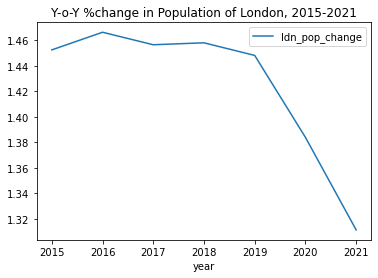

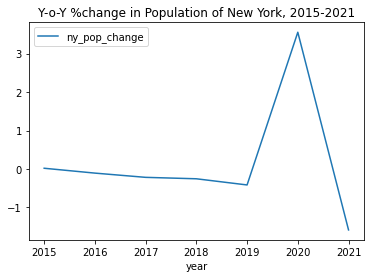

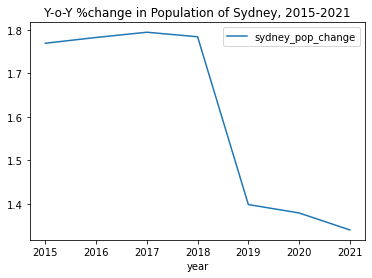

In [156]:
# See how population has evolved over time in each of the cities
pop_london.plot(x = 'year', y= 'ldn_pop_change', kind='line', title='Y-o-Y %change in Population of London, 2015-2021')
pop_ny.plot(x = 'year', y= 'ny_pop_change', kind='line', title='Y-o-Y %change in Population of New York, 2015-2021')
pop_sydney.plot(x = 'year', y= 'sydney_pop_change', kind='line', title='Y-o-Y %change in Population of Sydney, 2015-2021')

# Shows that population in all cities have been stable in the period of our analysis
# YoY growth has been on average pretty muted
# As such dont need to baseline cycling count data versus population data

### How has cycling uptake evolved?

London & its 3 regions

In [157]:
# Look now at how cycling uptake has evolved in London over the same period
# Introduce the merged london data set and recall the metadata
london_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657376 entries, 0 to 1657375
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Unnamed: 0                  1657376 non-null  int64  
 1   survey_year                 1657376 non-null  int64  
 2   site_id                     1657376 non-null  object 
 3   location                    1657376 non-null  object 
 4   survey_date                 1657376 non-null  object 
 5   weather                     1657376 non-null  object 
 6   time                        1657376 non-null  object 
 7   period                      1657376 non-null  object 
 8   direction                   1657376 non-null  object 
 9   number_of_male_cycles       375659 non-null   float64
 10  number_of_female_cycles     375659 non-null   float64
 11  number_of_unknown_cycles    375659 non-null   float64
 12  total_cycles                1657376 non-null  float64
 1

In [158]:
# Look now at how cycling uptake has evolved in London over the same period
# Ensure date is in appropriate format
london_complete['survey_date'] = pd.to_datetime(london_complete.survey_date)

# Aggregate by year
# Insert column year to run aggregation function
london_complete['year'] = london_complete['survey_date'].dt.year

In [159]:
# Fill all NaN values with 0
london_complete.fillna(0)

,Unnamed: 0,survey_year,site_id,location,survey_date,weather,time,period,direction,number_of_male_cycles,...,month,season,number_of_private_cycles,number_of_cycle_hire_bikes,surveydescription,latitude,longitude,borough,functional_cycling_area,year
0,0,2015,OUTCY049,High Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Northbound,2.0,...,1,Winter,0.0,0.0,Outer area cycle surveys,51.616595,-0.176770,Barnet,Outer,2015
1,1,2015,OUTCY049,High Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Southbound,10.0,...,1,Winter,0.0,0.0,Outer area cycle surveys,51.616595,-0.176770,Barnet,Outer,2015
2,2,2015,OUTCY104,Osidge Lane,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Eastbound,0.0,...,1,Winter,0.0,0.0,Outer area cycle surveys,51.631758,-0.144734,Barnet,Outer,2015
3,3,2015,OUTCY104,Osidge Lane,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Westbound,1.0,...,1,Winter,0.0,0.0,Outer area cycle surveys,51.631758,-0.144734,Barnet,Outer,2015
4,4,2015,OUTCY171,Lady Margaret Road,2015-01-05,Good,0600 - 0615,Early Morning (06:00-07:00),Northbound,0.0,...,1,Winter,0.0,0.0,Outer area cycle surveys,51.511893,-0.375539,Ealing,Outer,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657371,1657371,2019,INNCY559,Ruskin Park (Northway Road),2021-12-07,Unknown,2145 - 2200,Evening (19:00-22:00),Westbound,0.0,...,12,Winter,0.0,0.0,Inner area cycle surveys,51.465739,-0.096046,Lambeth,Inner,2021
1657372,1657372,2019,INNCY563,Brookmill Park,2021-12-07,Unknown,2145 - 2200,Evening (19:00-22:00),Northbound,0.0,...,12,Winter,0.0,0.0,Inner area cycle surveys,51.472101,-0.022461,Lewisham,Inner,2021
1657373,1657373,2019,INNCY563,Brookmill Park,2021-12-07,Unknown,2145 - 2200,Evening (19:00-22:00),Southbound,0.0,...,12,Winter,1.0,0.0,Inner area cycle surveys,51.472101,-0.022461,Lewisham,Inner,2021
1657374,1657374,2019,INNCY572,Brockwell Park,2021-12-07,Unknown,2145 - 2200,Evening (19:00-22:00),Northbound,0.0,...,12,Winter,0.0,0.0,Inner area cycle surveys,51.454975,-0.111665,Lambeth,Inner,2021


In [160]:
# Simplify df columns
london_complete=london_complete.drop(['Unnamed: 0', 'survey_year', 'site_id', 'time', 'location', 'direction', 
                                      'surveydescription', 'total_cycles'], axis=1)

In [161]:
# Insert a total count in outer london
london_complete['total_outer'] = london_complete['number_of_male_cycles']+london_complete['number_of_female_cycles']+london_complete['number_of_unknown_cycles']

In [162]:
# Insert a total count for inner and central london
london_complete['total_inn_cen'] = london_complete['number_of_private_cycles']+london_complete['number_of_cycle_hire_bikes']

In [163]:
# Fill all NaN values with 0
london_complete['total_outer'] = london_complete['total_outer'].fillna(0)
london_complete['total_inn_cen'] = london_complete['total_inn_cen'].fillna(0)

In [164]:
# Insert a global total uptake column for cycling counts in all areas of london
london_complete['total_uptake'] = london_complete['total_outer']+london_complete['total_inn_cen'] 

In [165]:
# Group by year to see change of total cycling uptake YoY
df= london_complete.groupby(['year'], as_index=False)['total_uptake'].sum()
df

,year,total_uptake
0,2014,1602997.0
1,2015,2138163.0
2,2016,2224386.0
3,2017,2222860.0
4,2018,2420240.0
5,2019,2429084.0
6,2020,1310615.0
7,2021,2119292.0


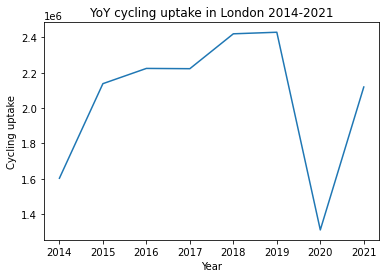

In [166]:
# Create the line chart to visualise the change
plt.plot(df['year'], df['total_uptake'])

# Adding the aesthetics
plt.title("YoY cycling uptake in London 2014-2021")
plt.xlabel('Year')
plt.ylabel('Cycling uptake')

# Show the plot
plt.show()

# Strong growth from 2014 onwards every year although slows down dramatically in 2018
# Big decline in 2019-2020 due to Covid-19 when lockdowns were in force
# Post pandemic recovery in numbers still below 2015
# Although 2021 numbers are not for full year, they do go up to end of first week of December 2021
# Shows that there is certainly room to increase cycling uptake from current levels
# Although expect that cycling counts should naturally creep up as post Covid normalisation continues

In [167]:
# Granularity on how total_uptake evolved in the 3 parts of London
df1= london_complete.groupby(['year', 'functional_cycling_area'], as_index=False)['total_uptake'].sum()
df1

,year,functional_cycling_area,total_uptake
0,2014,Central,1602997.0
1,2015,Central,1609705.0
2,2015,Inner,448419.0
3,2015,Outer,80039.0
4,2016,Central,1706122.0
5,2016,Inner,440588.0
6,2016,Outer,77676.0
7,2017,Central,1695344.0
8,2017,Inner,441995.0
9,2017,Outer,85521.0


In [168]:
# Visualise the changes
# Put all numbers on log scale to supress scalar affect
df1['log_total_uptake_ldn'] = np.log(df1['total_uptake']) 

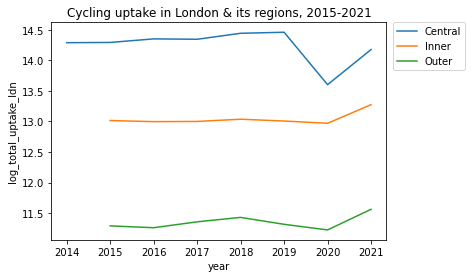

In [169]:
# Visualise change in uptake
g=sns.lineplot(x="year", y="log_total_uptake_ldn", data=df1, hue='functional_cycling_area')
g.set_title('Cycling uptake in London & its regions, 2015-2021')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Outer London uptake peaked in 2018 well before COVID
# Uptake in Outer London continued to drop during pandemic
# It has recovered above pre-pandemic peak

# Inner London uptake has been steady with almost no drop during COVID
# Uptake in Inner London has actually increased strongly post pandemic normalisation in 2020-21

# Central London uptake was increasing steadily until COVID
# Very sharp decline during COVID
# Strong recovery in post pandemic normalisation but has not recovered to pre-pandemic peak

New York

In [170]:
# Recall New York
ny_counts.info()

# Recall Sydney
sydney_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 9 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   day_of_week  object        
 3   month        int64         
 4   season       object        
 5   year         int64         
 6   hour         int64         
 7   time_of_day  object        
 8   counts       int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 286.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186 entries, 0 to 2214
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SiteID         2186 non-null   int64 
 1   Month          2186 non-null   object
 2   Year           2186 non-null   int64 
 3   TotalCount     2186 non-null   int64 
 4   Early_Morning  2186 non-null   int64 
 5   AM_Peak        2186 non-null   int64 
 6  

In [171]:
# Get overview of how cycling uptake has progressed over the years in New York
df3 = ny_counts.groupby(['year'], as_index=False)['counts'].sum()
df3

,year,counts
0,2012,1611856
1,2013,323533
2,2014,9261909
3,2015,13797937
4,2016,16005658
5,2017,14481794
6,2018,12542497
7,2019,12346460
8,2020,13577322
9,2021,13690962


In [172]:
# Put all numbers on log scale to supress scalar affects
df3['log_total_uptake_ny'] = np.log(df3['counts']) 
df3

,year,counts,log_total_uptake_ny
0,2012,1611856,14.292897
1,2013,323533,12.687056
2,2014,9261909,16.041421
3,2015,13797937,16.440030
4,2016,16005658,16.588453
5,2017,14481794,16.488403
6,2018,12542497,16.344633
7,2019,12346460,16.328880
8,2020,13577322,16.423911
9,2021,13690962,16.432246


Text(0, 0.5, 'Cycling uptake (log scale)')

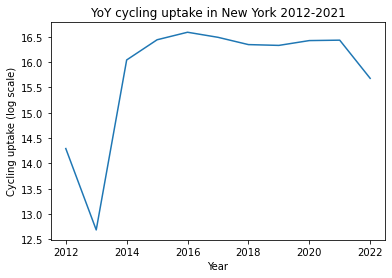

In [173]:
# Create the line chart to visualise the change
plt.plot(df3['year'], df3['log_total_uptake_ny'])

# Adding the aesthetics
plt.title("YoY cycling uptake in New York 2012-2021")
plt.xlabel('Year')
plt.ylabel('Cycling uptake (log scale)')

# Huge surge in 2013-2014
# What happened?
# Uptake was already declining since 2016
# In fact no major decline during COVID pandemic
# Another sharp decline in the post pandemic period
# Doesnt align with trends in London

Sydney

In [174]:
sydney_counts.sample()

,SiteID,Month,Year,TotalCount,Early_Morning,AM_Peak,PM_Peak
629,69,March,2017,305,34,97,174


In [175]:
# Change all column names to lower case to ease recalling them for analysis
sydney_counts = sydney_counts.rename(columns=str.lower)

In [176]:
# Get overview of how cycling uptake has progressed over the years in Sydney
df4 = sydney_counts.groupby(['year'], as_index=False)['totalcount'].sum()
df4

,year,totalcount
0,2010,59772
1,2011,79202
2,2012,95465
3,2013,106150
4,2014,114801
5,2015,96696
6,2016,95464
7,2017,101052
8,2018,44474
9,2019,97270


In [177]:
# Put all numbers on log scale to supress scalar affects
df4['log_total_uptake_sydney'] = np.log(df4['totalcount']) 
df4

,year,totalcount,log_total_uptake_sydney
0,2010,59772,10.998293
1,2011,79202,11.279757
2,2012,95465,11.466515
3,2013,106150,11.572608
4,2014,114801,11.650955
5,2015,96696,11.479327
6,2016,95464,11.466504
7,2017,101052,11.523391
8,2018,44474,10.702660
9,2019,97270,11.485246


Text(0, 0.5, 'Cycling uptake (log scale)')

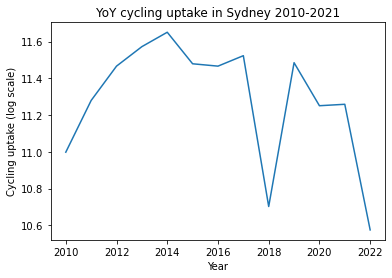

In [178]:
# Create the line chart to visualise the change
plt.plot(df4['year'], df4['log_total_uptake_sydney'])

# Adding the aesthetics
plt.title("YoY cycling uptake in Sydney 2010-2021")
plt.xlabel('Year')
plt.ylabel('Cycling uptake (log scale)')

# Peak uptake was in 2014 and has been in decline since
# Difficult to discern COVID impact as uptake cratered already in 2017
# What was behind that?
# Since 2017, annual uptake numbers have been very volatile in Sydney

In [179]:
df['log_total_uptake_ldn'] = np.log(df['total_uptake']) 

Combining all 3 cities

In [180]:
# Plot all regions/cities of interest in one chart
# Merge the dataframes
dfs = [df, df3, df4]
all_counts = ft.reduce(lambda left, right: pd.merge(left, right, on='year'), dfs)

In [183]:
# Trim the df
all_counts=all_counts.drop(['total_uptake', 'counts', 'totalcount'], axis=1)


In [184]:
# Melt the dataframe to plot all three cities into one chart
df5 = pd.melt(all_counts, id_vars =['year'], value_vars =['log_total_uptake_ldn', 'log_total_uptake_ny', 
                                                         'log_total_uptake_sydney'])
df5

,year,variable,value
0,2014,log_total_uptake_ldn,14.287386
1,2015,log_total_uptake_ldn,14.575458
2,2016,log_total_uptake_ldn,14.614991
3,2017,log_total_uptake_ldn,14.614305
4,2018,log_total_uptake_ldn,14.699377
5,2019,log_total_uptake_ldn,14.703025
6,2020,log_total_uptake_ldn,14.086007
7,2021,log_total_uptake_ldn,14.566593
8,2014,log_total_uptake_ny,16.041421
9,2015,log_total_uptake_ny,16.440030


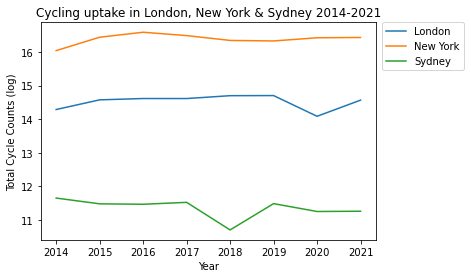

In [195]:
# Visualise change in uptake in all 3 cities
g=sns.lineplot(x="year", y="value", data=df5, hue='variable', legend=False)
g.set_title('Cycling uptake in London, New York & Sydney 2014-2021')
g.set(xlabel='Year', ylabel='Total Cycle Counts (log)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels=['London', 'New York', 
                                                                               'Sydney'])

# See if we can base 2014 to 100 and then plot as change to base.